# 500 Movies, 365 Days
On September 6th, 2015, I had a crazy idea: to watch as many movies as possible in the next year.

I mean, I was an 18-year-old living in one of the liveliest cities in the world, what else was I going to do?

And so, day after day, month after month, I sat inside and blew through almost 2 movies (~150 minutes) a day, a pace that seems almost unbelievable looking back. Maybe I anticipated that feeling, though, because I made sure to document it all from the beginning, recording each and every movie I watched (barring repeats -- yes, somehow, there *were* repeats) in an [Excel spreadsheet](https://docs.google.com/spreadsheets/d/1Kw9df_2tvPSE8elOUBhegwc7KzemsDof3v0_AL4CjoY/edit?usp=sharing), and even including information such as what I thought of the movies and who I watched them with.

Now, three years later, I thought it might be interesting to look back on my very own cinematic epic using my favorite programming language, Python, and some of the data tools that it provides.

## The Plan

### Goal
Investigate several questions related to my 2016 movie watching habits: What kinds of movies did I watch the most? Like the most? Who did I watch those movies with? What did critics think of them? 

### Steps:
*    Extract and clean the data from the spreadsheet
*    Supplement the existing data with additional information about each movie (stuff like genre, runtime, and critical reception)
*    Analyze the combined data to answer our target questions

## The Tools
For this task, we'll use[ Python 3.6.3](https://www.python.org/) through this [Jupyter Notebook](http://jupyter.org/). To be more precise, most of the heavy-lifting will be done by [Pandas](https://pandas.pydata.org), a Python module built specifically for manipulating data. In addition to that, we'll also be using a couple of other Python modules: [Matplotlib](https://matplotlib.org/), to visualize some of our findings, and [Requests](http://docs.python-requests.org/en/master/), to access our last tool, the [OMDb API](http://www.omdbapi.com/), via the HTTP web protocol.

## Extracting the Data
Before we do anything else, we need to get all of the information out of my Excel spreadsheet and into a format that we'll be able to work with in Python.

Luckily, Pandas provides a convenient function that will do exactly that automatically: `read_excel()`. It takes in a path to my spreadsheet (or, in this case, a link to its Google Drive download) and outputs a `DataFrame`, the data structure implemented by Pandas to facilitate working with large datasets. The function even allows us to choose which column of the spreadsheet to use as a row's primary identifier, or index, (we'll use the movies' titles) and to restrict the import to a certain number of columns. That last part is vital, since the spreadsheet does have some extraneous information. (Somewhere around January 2016, I decided it'd be fun to start doing "theme months," so I jotted down ideas for those in the spreadsheet's margins. Thankfully, I never got to Shrek month.)

In [1]:
import pandas as pd

# Import DataFrame from Excel spreadsheet
movies = pd.read_excel(io = 'https://drive.google.com/uc?export=download&id=1trwt1iqk0KmdpwgE8KxLd23LGJgFWhWQ', index_col = 0, usecols = 5)

print(movies.head())

                     Date (Completed) Rating With Watched Before? In Theater?
Movie                                                                        
Strangers on a Train       2015-09-06      B  NaN             NaN         NaN
Trainwreck                 2015-09-06     B-  Max             Yes         Yes
Dark Places                2015-09-07     C+  NaN             NaN         NaN
The Visit                  2015-09-08      A  Max             Yes         Yes
Psycho                     2015-09-10     A-  NaN             NaN         NaN


Cool. As you can see, now we have all of our data in a Pandas `DataFrame`, which we can conveniently using the `head()` method. However, you'll also notice that the data looks a little... funky, what with all those unclear column titles and NaNs everywhere. We should probably clean it up a little. We'll make three changes:

1.   Retitle some of the columns (called Series now that they're in the DataFrame) for clarity.
2.   Tweak some of the data entries so that they look nicer and are theoretically easier to work with (changing "Yes" and "No" to boolean values and clarifying that movies not watched with anybody else were watched alone).
3.   Convert the letter grades I gave to each movie into numerical ratings.

In [2]:
# Rename columns
movies.rename(columns = {'Date (Completed)': 'date_watched', 'Rating': 'score', 'With': 'watched_with',
    'Watched Before?': 'watched_before', 'In Theater?': 'watched_in_theater'}, inplace = True)

# Fix watched_before and watched_in_theater
movies.watched_before = (movies.watched_before == 'Yes')
movies.watched_in_theater = (movies.watched_in_theater == 'Yes')
movies.watched_with.fillna('Alone', inplace = True)

# Fix score
letters = {'A': 93, 'B': 72, 'C': 51, 'D': 30, 'F': 9}
marks = {'-': -7, '+': 7}

def rating_to_score(rating):
    '''Converts one of Freshman Sam's letter grades to a numerical score out of 100'''
    return letters[rating[0]] + (marks[rating[1]] if (len(rating) > 1 and rating[1]) in marks else 0)

movies.score = movies.score.apply(rating_to_score)

print(movies.head())

                     date_watched  score watched_with  watched_before  \
Movie                                                                   
Strangers on a Train   2015-09-06     72        Alone           False   
Trainwreck             2015-09-06     65          Max            True   
Dark Places            2015-09-07     58        Alone           False   
The Visit              2015-09-08     93          Max            True   
Psycho                 2015-09-10     86        Alone           False   

                      watched_in_theater  
Movie                                     
Strangers on a Train               False  
Trainwreck                          True  
Dark Places                        False  
The Visit                           True  
Psycho                             False  



Looking pretty good!

But our data is a little basic. There's a few simple conclusions we could try to draw from what we have, like how many movies I rated less than 30 out of 100 (only eleven, by the way, shoutout to [*The Final Project*](https://www.imdb.com/title/tt3758334/), the only F on the original scale), but we could do a lot more with a little extra information. For example, what if we could somehow add the generic information about each movie that I didn't bother including in the spreadsheet to our `DataFrame`?

## Supplementing our Data
Adding stuff to our `DataFrame` is relatively simple, as we'll see soon enough, but the difficult part is *getting* the stuff.

One option would be to Google each movie and see what we could find, adding pieces of information to the `DataFrame` manually, one by one. That would probably take a while (maybe not as long as watching 500 movies, but still). And, if you think about it, odds are most of our searches would end at [IMDb](https://www.imdb.com/), since it will likely have any information we want about any movie in our dataset. Just searching IMDb for each movie would probably be a little faster, but wouldn't it be great if we could do all of that it automatically?

Enter the [OMDb API](http://www.omdbapi.com/). Basically, it provides a standardized format for us to perform IMDb searches via code. We send some data, including a movie's title, and, optionally, its release year, to the API via an HTTP request and it sends us back information pulled right from the target movie's IMDb page in the easily-parsable JSON format. We can write a function that uses the [Requests](http://docs.python-requests.org/en/master/) module to make the HTTP request a little easier for us.

In [3]:
# Setup OMDb API function
import requests

def imdb_search(title, year = None):
    '''Attempts an IMDb search for the given title (and optionally release year) via the OMDb API and returns the response if successful or None if unsuccessful'''
    response = requests.get('http://www.omdbapi.com/', params = {'apikey': 'a19d8af5', 't': title, 'y': year}).json()
    return response if response['Response'] == 'True' else None
  
print(imdb_search(title = 'All About Steve'))

{'Title': 'All About Steve', 'Year': '2009', 'Rated': 'PG-13', 'Released': '04 Sep 2009', 'Runtime': '99 min', 'Genre': 'Comedy, Romance', 'Director': 'Phil Traill', 'Writer': 'Kim Barker', 'Actors': 'Sandra Bullock, Thomas Haden Church, Bradley Cooper, Ken Jeong', 'Plot': 'Convinced that a CCN cameraman is her true love, an eccentric crossword puzzler trails him as he travels all over the country, hoping to convince him that they belong together.', 'Language': 'English, Spanish, French, American Sign Language', 'Country': 'USA', 'Awards': '2 wins & 3 nominations.', 'Poster': 'https://m.media-amazon.com/images/M/MV5BMTA5MTQxOTE2OTReQTJeQWpwZ15BbWU3MDY5NzI4NzI@._V1_SX300.jpg', 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '4.8/10'}, {'Source': 'Rotten Tomatoes', 'Value': '7%'}, {'Source': 'Metacritic', 'Value': '17/100'}], 'Metascore': '17', 'imdbRating': '4.8', 'imdbVotes': '36,076', 'imdbID': 'tt0881891', 'Type': 'movie', 'DVD': '22 Dec 2009', 'BoxOffice': '$33,806,061', 

They even have *All About Steve*! We're set!

Now, all we need to do is call this function once for every movie, using the movie's title as a parameter, and it will return each of the OMDb responses. For now, we'll collect everything in a dictionary that associates each title with its IMDb info.

We'll also make sure that we have a seperate list that we can log a movie's title to if its OMDb request fails, just in case something goes wrong.

...because of course some things are going to go wrong.

Our first attempt worked for 458 of the movies, but the OMDb request failed for about 40 of them.

From our list of failed titles, it's pretty easy to see why our strategy didn't always work. There are a few reasons:

1.   Some movies have their release year included in parenthesis after their titles. This makes sense, to distinguish between movies that may have the same title, but IMDb doesn't really recognize the convention, so it threw off the searches.
2.   Other movies, like *The Exorcist*, have other parentheticals, like to specify that I watched the *(Director's Cut)*. Since it's not too important (seriously, they just add a couple of jump scares with a dude in Halloween paint), we'll just ignore these moving forward. 
3.   IMDb lists foreign movies under translated titles, whereas Freshman Sam thought it was cool to record them using their romanized title. I assume this dedication to cultural purity means he watched *Er ist wieder da* in its native German. (He didn't.) 
4.   Apparently, Freshman Sam also doesn't know how to spell *Despicable Me*. Utterly dispicable.

Luckily, these problems are all pretty easy to fix.

For #1 and 2, we'll use the regular expressions functions from Python's standard library to remove parentheticals from movie titles, then repeat our search using the new title, throwing in the release year for good measure if it's available (remember, the OMDb function we wrote before makes this easy).

When doing this, we should correct the titles in the DataFrame from before, too, to make it easier to merge all of our data later.

In [4]:
# Try to retrieve info for each movie
imdb_dict = {} # {title: imdb_json}, dictionary of information that OMDb successfully retrieved
failed_titles = [] # list of titles that OMDb requests failed for

for title in movies.index:
    # Get OMDB response
    response = imdb_search(title = title)
    # If OMDb returned a response, add the movie to the dictionary 
    if response != None:
        imdb_dict[title] = response
    # Otherwise, add the movie to the failed titles list
    else:
        failed_titles.append(title)

print('Successfully retrieved IMDb info for', len(imdb_dict), 'movies')
print('Failed to retrieve info for', len(failed_titles), 'movies. Here they are:')
print(failed_titles)

Successfully retrieved IMDb info for 458 movies
Failed to retrieve info for 42 movies. Here they are:
['Love and Mercy', 'Almost Famous (Bootleg Cut)', 'Batman: The Mask of Phantasm', "The Exorcist (Director's Cut)", 'Casino Royale (2006)', 'A Nightmare on Elm Street (1984)', "Wes Craven's New Nightmare", 'Krampus (WIP)', 'The Hunger Games: Mockingjay Part II', 'Planes, Trains and Automobiles', 'Halloween (1978)', 'Almost Famous (Theatrical Cut)', 'When a Stranger Calls (1979)', 'Les Garçons et Guillaume, à table!', 'Equals (WIP)', 'Star Wars: Return of the Jedi (DVD)', 'Dispicable Me', 'Dispicable Me 2', 'Spy Kids 3D Game Over', 'Spy Kids 2: The Island of Lost Dreams', 'The Room (Rifftrax)', 'Prom Night (1980)', 'Blade Runner (Final Cut)', 'The Divergent Series: Allegiant', 'Watchmen (Ultimate Cut)', 'The Jungle Book (2016)', 'Er ist wieder da', 'Gokseong', 'Adventures in Babysitting (2016)', 'The Evil Dead (1981)', 'Batman v Superman: Dawn of Justice (Ultimate Edition)', 'Ecstacy of 

In [5]:
# Fix parenthetical failures
import re

for old_title in failed_titles:
    if '(' in old_title:
        # Split actual title and parenthetical
        new_title = old_title.split(' (')[0]
        parenthetical = old_title.split(' (')[1].replace(')', '')
        # Get year if available
        year = parenthetical if re.search('[0-9]*', parenthetical).group(0) else None
        # Get OMDb response
        response = imdb_search(title = new_title, year = year)
        # If OMDb returned a response, add the movie to the dictionary and update the movie title in the DataFrame
        if response != None:
            imdb_dict[new_title] = response
            movies.rename(index = {old_title: new_title}, inplace = True)
            
print(imdb_dict['Casino Royale'])
print('Now we have IMDb info for', len(imdb_dict), 'movies')

{'Title': 'Casino Royale', 'Year': '2006', 'Rated': 'PG-13', 'Released': '17 Nov 2006', 'Runtime': '144 min', 'Genre': 'Action, Adventure, Thriller', 'Director': 'Martin Campbell', 'Writer': 'Neal Purvis (screenplay), Robert Wade (screenplay), Paul Haggis (screenplay), Ian Fleming (novel)', 'Actors': 'Daniel Craig, Eva Green, Mads Mikkelsen, Judi Dench', 'Plot': 'Armed with a license to kill, Secret Agent James Bond sets out on his first mission as 007, and must defeat a private banker to terrorists in a high stakes game of poker at Casino Royale, Montenegro, but things are not what they seem.', 'Language': 'English, French', 'Country': 'UK, Czech Republic, USA, Germany, Bahamas, Italy', 'Awards': 'Won 1 BAFTA Film Award. Another 26 wins & 44 nominations.', 'Poster': 'https://m.media-amazon.com/images/M/MV5BMDI5ZWJhOWItYTlhOC00YWNhLTlkNzctNDU5YTI1M2E1MWZhXkEyXkFqcGdeQXVyNTIzOTk5ODM@._V1_SX300.jpg', 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '8.0/10'}, {'Source': 'Rotten


For #3 and 4, we'll just correct the titles manually before repeating our searches. Since there are only about 20 movies left for us to search, this isn't too much of a hassle. Just like with all the others, though, we'll need to make the same corrections in our `DataFrame`.

In [6]:
# Fix other failures
corrected_titles = {'Love and Mercy': 'Love & Mercy', 'Batman: The Mask of Phantasm': 'Batman: Mask of the Phantasm',
    'Wes Craven\'s New Nightmare': 'New Nightmare', 'The Hunger Games: Mockingjay Part II': 'The Hunger Games: Mockingjay - Part 2',
    'Planes, Trains and Automobiles': 'Planes, Trains & Automobiles', 'Les Garçons et Guillaume, à table!': 'Me, Myself, and Mum',
    'Star Wars: Return of the Jedi (DVD)': 'Star Wars: Episode V - The Empire Strikes Back', 'Dispicable Me': 'Despicable Me',
    'Dispicable Me 2': 'Despicable Me 2', 'Spy Kids 3D Game Over': 'Spy Kids 3: Game Over',
    'Spy Kids 2: The Island of Lost Dreams': 'Spy Kids 2: Island of Lost Dreams', 'The Divergent Series: Allegiant': 'Allegiant',
    'Er ist wieder da': 'Look Who\'s Back', 'Gokseong': 'The Wailing', 'Ecstacy of Order: The Tetris Masters': 'Ecstasy of Order: The Tetris Masters',
    'Terminator 2: Judgement Day': 'Terminator 2', 'Lilo and Stitch': 'Lilo & Stitch',
    'Indiana Jones and the Raiders of the Lost Ark': 'Raiders of the Lost Ark', 'Pokemon 3: The Movie: Spell of the Unown': 'Pokémon 3: The Movie',
    'Mechanic: Ressurection': 'Mechanic: Resurrection'}

for old_title, new_title in corrected_titles.items():
    # Add response to dictionary
    imdb_dict[new_title] = imdb_search(title = new_title)
    # Update movie title in the DataFrame
    movies.rename(index = {old_title: new_title}, inplace = True)
    
print(imdb_dict['Love & Mercy'])
print('Now we have IMDb info for', len(imdb_dict), 'movies')

{'Title': 'Love & Mercy', 'Year': '2014', 'Rated': 'PG-13', 'Released': '19 Jun 2015', 'Runtime': '121 min', 'Genre': 'Biography, Drama, Music', 'Director': 'Bill Pohlad', 'Writer': 'Oren Moverman, Michael A. Lerner, Brian Wilson (based on the life of)', 'Actors': 'Paul Dano, John Cusack, Elizabeth Banks, Paul Giamatti', 'Plot': 'In the 1960s, Beach Boys leader Brian Wilson struggles with emerging psychosis as he attempts to craft his avant-garde pop masterpiece. In the 1980s, he is a broken, confused man under the 24-hour watch of shady therapist Dr. Eugene Landy.', 'Language': 'English', 'Country': 'USA', 'Awards': 'Nominated for 2 Golden Globes. Another 20 wins & 55 nominations.', 'Poster': 'https://m.media-amazon.com/images/M/MV5BMTk1MTkwMzU4Nl5BMl5BanBnXkFtZTgwNjY0MDE1NTE@._V1_SX300.jpg', 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '7.4/10'}, {'Source': 'Rotten Tomatoes', 'Value': '91%'}, {'Source': 'Metacritic', 'Value': '80/100'}], 'Metascore': '80', 'imdbRating':

Great! Now we have the IMDb data for all of the movies in the dataset (we're just a little under 500 because we're ignoring the different versions of certain movies that Freshman Sam decided to list twice, such as *Almost Famous*'s *Bootleg* and *Original* cuts).

But, of course, we should probably clean this up a little, too. For one, all of the data is still in JSON format.

Once again, Pandas provides a function that will build us a DataFrame, this time out of our list of JSON objects, which we can index by the movie titles just like our first `DataFrame`.

In [7]:
# Make dictionary into DataFrame
imdb = pd.DataFrame.from_dict(data = imdb_dict, orient = 'index')

print(imdb.head())

                                       Title  Year  Rated     Released  \
10 Cloverfield Lane      10 Cloverfield Lane  2016  PG-13  11 Mar 2016   
2001: A Space Odyssey  2001: A Space Odyssey  1968      G  12 May 1968   
21                                        21  2008  PG-13  28 Mar 2008   
21 Jump Street                21 Jump Street  2012      R  16 Mar 2012   
28 Days                              28 Days  2000  PG-13  14 Apr 2000   

                       Runtime                   Genre  \
10 Cloverfield Lane    103 min  Drama, Horror, Mystery   
2001: A Space Odyssey  149 min       Adventure, Sci-Fi   
21                     123 min  Crime, Drama, Thriller   
21 Jump Street         109 min   Action, Comedy, Crime   
28 Days                103 min           Comedy, Drama   

                                            Director  \
10 Cloverfield Lane                 Dan Trachtenberg   
2001: A Space Odyssey                Stanley Kubrick   
21                                    


Now, we can manipulate it similarly to how we worked with our first DataFrame. Again, we'll make three changes:

1.   Add a Series of Rotten Tomatoes ratings for convenience (for some reason the API returns Metacritic and IMDb ratings at the top level of the JSON objects, but Rotten Tomatoes ratings are hidden within the "Ratings" objects).
2.   Remove unnecessary Series.
3.   Rename Series we want to keep.
4.   Tweak some of the data entries so that they're easier to work with. Specifically, we need to clean the IMDb, Metascore, and Rotten Tomatoes Series so they conform to our 100-point scale and absent values are dealt with, and we'll convert movie runtimes to minute integers.

In [8]:
# Add Rotten Tomatoes Series
def get_rt_rating(ratings):
    for rating in ratings:
        if rating['Source'] == 'Rotten Tomatoes' and rating['Value'] != 'N/A':
            return int(rating['Value'].replace('%', ''))

imdb['rotten_tomatoes'] = imdb.Ratings.apply(get_rt_rating)

# Drop what we don't want
imdb.drop(['Awards', 'DVD', 'Plot', 'Response', 'Type', 'Poster', 'Title', 'Released', 'Website', 'imdbID', 'BoxOffice',
    'imdbVotes', 'totalSeasons', 'Ratings'], axis = 1, inplace = True)

# Rename what we want to keep
imdb.rename(columns = {'Actors': 'actors', 'Country': 'countries',
    'Director': 'directors', 'Genre': 'genres', 'Metascore': 'metascore', 'Language': 'languages', 'Production': 'studio',
    'Rated': 'rated', 'Runtime': 'runtime', 'imdbRating': 'imdb_rating', 'Year': 'release_year',
    'Writer': 'writers'}, inplace = True)

# Fix Metascores 
imdb.metascore = imdb.metascore.apply(lambda metascore: int(metascore) if metascore != 'N/A' and metascore != None else None)

# Fix IMDb ratings
imdb.imdb_rating = imdb.imdb_rating.apply(lambda imdb_rating: int(float(imdb_rating) * 10) if imdb_rating != 'N/A' and imdb_rating != None else None)

# Fix runtimes
imdb.runtime = imdb.runtime.apply(lambda runtime: int(runtime.split(' ')[0]) if runtime != 'N/A' and runtime != None else None)

print(imdb.head())

                      release_year  rated  runtime                  genres  \
10 Cloverfield Lane           2016  PG-13    103.0  Drama, Horror, Mystery   
2001: A Space Odyssey         1968      G    149.0       Adventure, Sci-Fi   
21                            2008  PG-13    123.0  Crime, Drama, Thriller   
21 Jump Street                2012      R    109.0   Action, Comedy, Crime   
28 Days                       2000  PG-13    103.0           Comedy, Drama   

                                           directors  \
10 Cloverfield Lane                 Dan Trachtenberg   
2001: A Space Odyssey                Stanley Kubrick   
21                                    Robert Luketic   
21 Jump Street         Phil Lord, Christopher Miller   
28 Days                                 Betty Thomas   

                                                                 writers  \
10 Cloverfield Lane    Josh Campbell (screenplay by), Matthew Stuecke...   
2001: A Space Odyssey  Stanley Kubrick (sc

With our second `DataFrame` all cleaned up, we're ready to put everything together. Since both of our DataFrames are consistently indexed by the movies' titles, we can join them together using that.

In [9]:
# Join to movies
movies = imdb.join(movies)

print(movies.head())

                      release_year  rated  runtime                  genres  \
10 Cloverfield Lane           2016  PG-13    103.0  Drama, Horror, Mystery   
2001: A Space Odyssey         1968      G    149.0       Adventure, Sci-Fi   
21                            2008  PG-13    123.0  Crime, Drama, Thriller   
21 Jump Street                2012      R    109.0   Action, Comedy, Crime   
28 Days                       2000  PG-13    103.0           Comedy, Drama   

                                           directors  \
10 Cloverfield Lane                 Dan Trachtenberg   
2001: A Space Odyssey                Stanley Kubrick   
21                                    Robert Luketic   
21 Jump Street         Phil Lord, Christopher Miller   
28 Days                                 Betty Thomas   

                                                                 writers  \
10 Cloverfield Lane    Josh Campbell (screenplay by), Matthew Stuecke...   
2001: A Space Odyssey  Stanley Kubrick (sc

I promised it'd be easy. Now there's only one thing left to do!

## Analyzing the Data
As I mentioned before, we'll be pulling in another module to visualize our data. [Matplotlib](https://matplotlib.org/) makes it very easy to turn our Pandas `DataFrame` into just about any graph we want. All we need to do is tell the `DataFrame` (or a `Series` inside of it) what kind of plot we want, then call Matplotlib's `show()`` function.

Let's try it out first with a boxplot to quickly see the general distribution of scores that I gave to the movies in our dataset.

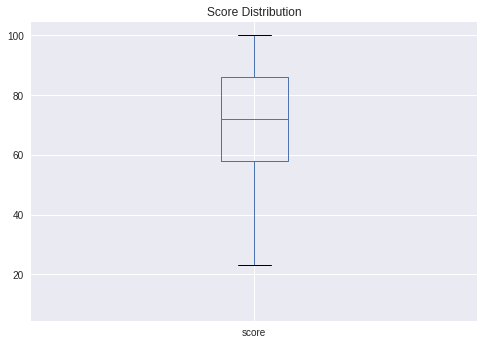

In [10]:
import matplotlib.pyplot as plt

# What was the general distribution of scores I gave?
movies.score.plot.box(title = 'Score Distribution')
plt.show()

Interesting. The box tells us that I gave scores of over 50 (around a C on my letter grade scale) to at least 75% of the movies I watched, and scores of over 80 (around a B+) to at least 125 of those. I guess if you're going to spend so much time watching movies, might as well enjoy them.

Speaking of, it might also be interesting to see how much time. IMDb gave us runtimes for most of our movies in minutes, so let's add them up. We can even compare that to the total number of minutes in a year (525,600) to see how much of the entire year I spent watching movies.

In [11]:
# How long did I spend watching movies?
print('I spent', movies.runtime.sum(), 'minutes watching movies')
print('That\'s', movies.runtime.sum() / 525600 * 100, '% of the entire year')

I spent 54289.0 minutes watching movies
That's 10.328957382039574 % of the entire year


Nevermind, it wasn't interesting. Just kind of sad.

But none of that really helps us with our target questions. I wanted to learn what *kind* of movies I watched and liked the most, and looking at movies neither individually or in total can answer that for us. We need a way to sort the movies by genre, then we can count the number of movies in each genre and even look at all of their scores together.

First thing's first: it would be easy to group movies by the data they have in a specific column. For example, we could split the movies into two sets, "watched in theaters" and "not watched in theaters" according to whether "True" or "False" is in their "watched_with" column -- Pandas even has a `groupby()` function specifically for this purpose.

However, thinking about the data we have, our "genre" `Series` pulled from IMDb contains *strings* listing each movie's genres in the format "Action, Comedy, Horror" which is a little harder to deal with, as we would like to look at each genre seperately, and movies can have multiple genres (that example before was from *Scouts Guide to the Zombie Apocalypse*, by the way, which was... weird).

With this in mind, the best approach may be to determine all of the possible genres that could be in these strings, then use that knowledge build a `Series` that relates each genre to the number of times it appears in all of the strings that we can graph in a pie chart.

We'll use Python strings' `split()` function to create a huge list of all of the genres from all of the movies, then the language's built-in set data type to get rid of duplicates, resulting in a grouping of all the unique genres represented in the dataset. Then we'll iterate through each of these genres and count the number of movies in the dataset that feature that genre (using Panda's helpful `str.contains()` function) to reach our desired result.

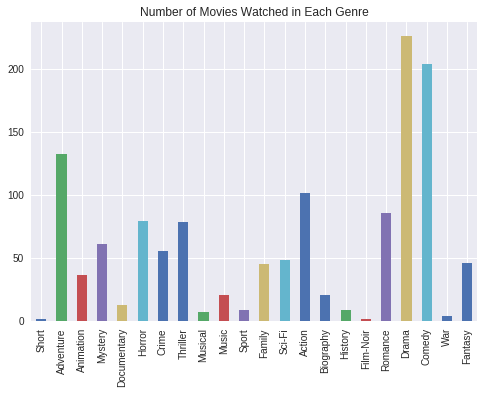

In [12]:
# How many movies did I watch in each genre?
all_genres = set([genre for genres in movies.genres for genre in genres.split(', ')])
genre_nos = pd.Series([movies[movies.genres.str.contains(genre)].index.size for genre in all_genres], index = all_genres)

genre_nos.plot.bar(title = 'Number of Movies Watched in Each Genre')
plt.show()

What can I say, Drama follows me.

Let's use the work we already did to see what genre of movie I tended to *like* the most. We have our list of all possible genres, so, this time, let's use it to build a `Series` that averages the scores of all the movies that have each genre in their genre list, then use a bar graph to compare them with each other. So that our results aren't skewed by my apparent love for short film, we should make sure to exclude genres that have less than 10 entries (our `Series` of genre counts from before makes it easy).

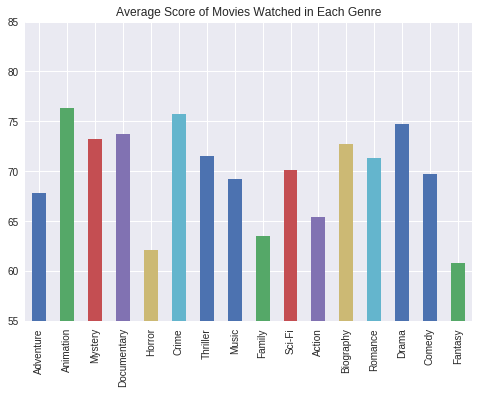

In [13]:
# What was my average score for each genre?
avg_score_genre = pd.Series([movies[movies.genres.str.contains(genre)].score.mean() for genre in all_genres if genre_nos[genre] > 10], index = [genre for genre in all_genres if genre_nos[genre] > 10])

avg_score_genre.plot.bar(title = 'Average Score of Movies Watched in Each Genre', ylim = [55, 85])
plt.show()


This one is pretty surprising to me, since I don't really consider myself an animation person (except Frozen -- love me some Frozen), but you'll notice that I actually had to tighten up this graph's vertical axis because the average scores were just so close together. The difference between the maximum (**Animation**, at **76.3**) and minimum (**Fantasy,** at **60.7**) average scores is a mere **15.6** points. This tells me that my average score is fairly consistent across the genres that I watched, and it's unsurprising that those average scores are pretty close to the overall median score shown by my first boxplot, **72.0**.

Alright, now let's find out who I watched the most movies with. Notice that our DataFrame's "watched_with" *Series* is actually very similar to its "genre" Series, with strings listing who I watched each movie with in the format of "Bele, Georgia, Vern, Tyler, Mom, and Lance" (*The Legend of Tarzan*, not a great 4th of July movie, by the way -- also not a great, uh, *movie*). So it stands to reason that we can use the same strategy of gathering all of the unique people I watched movies with, building a `Series` that shows us the actual number of movies I watched with each of them, and then displaying the information in a pie chart. We'll ignore people who watched less than 3 movies with me, because they clearly just weren't committed enough to the project.

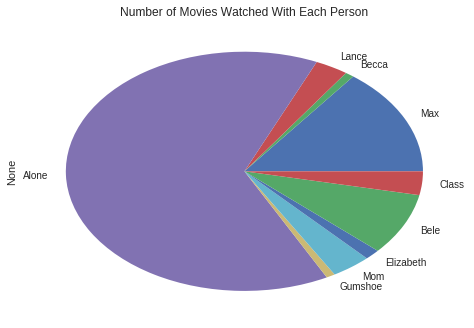

In [14]:
# How many movies did I watch with each person?
all_people = set([person for people in movies.watched_with for person in people.replace(', and ', ',').replace(' and ', ', ').split(', ')])
people_nos = pd.Series([movies[movies.watched_with.str.contains(person)].index.size for person in all_people], index = all_people)

people_nos[people_nos > 3].plot.pie(title = 'Number of Movies Watched With Each Person')
plt.show()

Again, a little sad. Though I will reiterate that I didn't record repeat viewings in the spreadsheet, which probably hurt my friend Max's viewcount more than anybody. We do, like, 10 Pirates of the Carribbean marathons a year. 20 for the Dark Knight trilogy.

Okay, maybe that's even more sad.

Anyway, to see what my average score was for the movies I watched with each person, we can again pretty much just do the same thing that we did with the genres, using Panda's `str.contains()` function to get the means of the scores of all movies that have a "watched_with" string that contains each person's name and comparing them all in a bar graph.

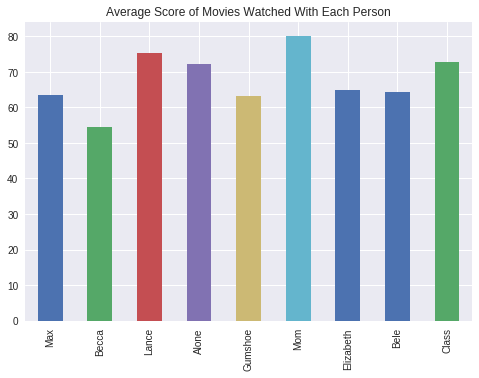

In [15]:
# Who did I watch the movies I liked the most with?
avg_score_with = pd.Series([movies[movies.watched_with.str.contains(person)].score.mean() for person in all_people if people_nos[person] > 3], index = people_nos[people_nos > 3].index)

avg_score_with.plot.bar(title = 'Average Score of Movies Watched With Each Person')
plt.show()


Alright, maybe I do have a favorite genre, because about all my mom and I watch together are early 90s political thrillers. And things starring Cher. So, one of those.

I've also got to say I'm a little shocked my average rating for movies I watched with my sister Becca is almost 30 points lower, since I don't remember watching much of anything with her (I guess *Valentine's Day* didn't make much of an impression on me).

Honestly, I was expecting my lowest average to go to either my other sister, Bele, or one of my friends Max or Gumshoe, considering we all make a habit of watching pretty horrible movies when we get together. But I'll be the first to admit that my scores on those particular outings could've been a little skewed (I gave *The Wizard* a 45, and that's adding roughly 70 so-bad-it's-good points).

Now let's tackle the last question area I wanted to look at: comparing my movie scores to the ones IMDb made available to us.

Of course, we should always be aware of the differences between the types of scores on a fundamental level (like how my scores were originally written as letter grades, how IMDb ratings are user scores, Metacritic's are averaged critics', and how Rotten Tomatoes's Tomatometer really just measures the percentage of critics that "liked" the movie), but, thanks to the work we did in cleaning up the score Series earlier, it's pretty easy for us to create a new Series for each of them that subtracts that source's scores from mine. If we take these Series' mean, we can see how much my scores differ from each source's scores on average.

My scores were 0.09853249475890985 above Rotten Tomatoes ratings on average.
My scores were 6.554838709677419 above Metascores ratings on average.
My scores were 0.7014028056112225 above IMDb ratings on average.


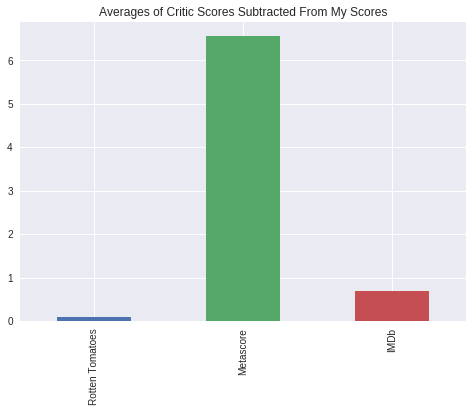

In [16]:
# How do my scores compare to the critics?

# Rotten Tomatoes
movies['vs_rt'] = movies.score - movies.rotten_tomatoes
print('My scores were', movies.vs_rt.mean(), 'above Rotten Tomatoes ratings on average.')

# Metascore
movies['vs_metascore'] = movies.score - movies.metascore
print('My scores were', movies.vs_metascore.mean(), 'above Metascores ratings on average.')

# IMDb
movies['vs_imdb'] = movies.score - movies.imdb_rating
print('My scores were', movies.vs_imdb.mean(), 'above IMDb ratings on average.')

vs_critics = pd.Series([movies.vs_rt.mean(), movies.vs_metascore.mean(), movies.vs_imdb.mean()], index = ['Rotten Tomatoes', 'Metascore', 'IMDb'])
vs_critics.plot.bar(title = 'Averages of Critic Scores Subtracted From My Scores')
plt.show()

*Damn*. I've usually felt like Rotten Tomatoes scores were pretty well aligned with my tastes, but I wasn't quite expecting that. Beyond that, I'm a little disappointed in how well my scores match up with IMDb user rankings (reminder, going by those, Christopher Nolan has directed like 10 out of the top 15 movies of all time). And I guess the fact that I gave scores that were, on average, almost 7 points higher than the ones that Metascore aggregated is evidence of the fact that I'm a little more forgiving than the average movie critic. And that, again, I like some *bad* movies. (One of the biggest differences between my score and a Metascore score was *Annie (2014)*, which Metascore's algorithm gave a 33 to my 86. Haters.)

## Final Thoughts
When I started my movie-watching journey back in September 2015, I don't think I even had a concept of what 500 movies *looked* like. One year later, I guess I did (technically, I *had* looked at them all), and I spent a fair amount of time scrolling aimlessly through my massive spreadsheet, but I really have appreciated finally revisiting the data as a whole in a way that I can understand.

While I can't recommend watching so many movies in so short a time, it is a fun thing to look back on. That's 500 movies, one whole year of my life (or, at least 10.3% of a year), that I'll always be able to remember with just a little data cleaning, just a couple of lines of code.

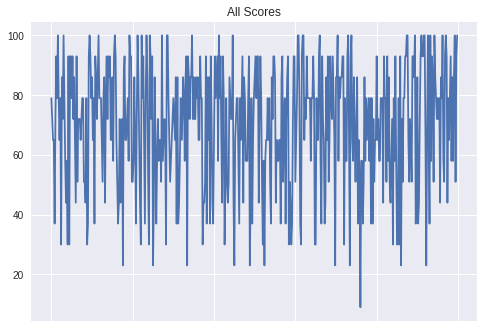

In [17]:
# All of my scores
movies.score.plot.line(title = 'All Scores')
plt.show()

Feel free to take a look at my original Excel spreadsheet [here](https://docs.google.com/spreadsheets/d/1Kw9df_2tvPSE8elOUBhegwc7KzemsDof3v0_AL4CjoY/edit?usp=sharing), or the final dataset I performed analysis on in .csv format [here](https://drive.google.com/open?id=1mmB2hmhBriiWIQ_6vyf5L3Lcvzqh3BM9). Both are also available in this GitHub repository.

Thanks for reading. And thanks, especially, for not making fun of my 2015 movie tastes.

In [18]:
# What score did I give to Borat?
print(movies.loc['Borat'].score)

100


Okay, we can make fun of them a little.